## 1 -  Importar bibliotecas 

Para esse projeto, as seguintes bibliotecas foram utilizadas com as respectivas funções:

- Selenium e Webdriver: interação com o navegador e coleta dos dados 
- Pandas: trabalhar com as tabelas e dataframes
- Time: aguardar as páginas carregarem
- Win32com: enviar email 

In [9]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
import win32com.client as win32


## 2 - Importar planilha inicial 

Importação da planilha que contém quais produtos vamos buscar, seus limites de preço e também alguns termos banidos, que são termos que não desejamos que estejam nos produtos que estamos pesquisando (para garantir que vamos pegar os itens certos)

In [10]:
tabela_busca = pd.read_excel('buscas.xlsx')
display (tabela_busca)


,Nome,Termos banidos,Preco minimo,Preco maximo
0,iphone 12 64 gb,mini watch 11,3200,4100
1,rtx 3060,zota galax,2400,2800


## 3 - Abrir o navegador

In [11]:
servico = Service(ChromeDriverManager().install())
navegador = webdriver.Chrome(service=servico)

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 105.0.5195
[WDM] - Get LATEST chromedriver version for 105.0.5195 google-chrome
[WDM] - Driver [C:\Users\bruno\.wdm\drivers\chromedriver\win32\105.0.5195.52\chromedriver.exe] found in cache


## Acessar os sites escolhidos, pesquisar sobre os produtos e armazenar em um dataframe

Para isso, utilizou-se o Selenium com o intuito de conseguir realizar comunicações e operações com os sites e buscar o preço dos produtos desejados.
Com os produtos e preços em mãos, algumas condições foram aplicadas (preço mínino, preço máximo, termos banidos e termos obrigatórios) para salvarmos em um dataframe somente os produtos desejados.

In [12]:
#mudando a coluna de termos banidos para ficar em forma de lista
tabela_busca['Termos banidos'] = tabela_busca['Termos banidos'].str.split(' ')

#Criando uma coluna com os termos do nome do produto em forma de lista para depois garantirmos que todos os termos estarão no item encontrado
tabela_busca['Termos nome'] = tabela_busca['Nome'].str.split(' ')

#criando dicionário com o nome das colunas que eu quero na tabela final
dicionario_link_preco = {'Nome':[],'Link':[], 'Preço': []}

#pesquisar o item no primeiro site (google shopping)
for produto in tabela_busca['Nome']:
    
    #acessar o Google Shopping
    navegador.get('https://shopping.google.com.br/?nord=1')
    time.sleep(1)

    campo_busca_google = navegador.find_element(By.NAME, 'q')
    campo_busca_google.clear()
    campo_busca_google.send_keys(produto, Keys.ENTER)
    time.sleep(2)
    
    #definindo o preço mínimo e máximo 
    preco_minimo = tabela_busca.loc[tabela_busca['Nome']==produto, 'Preco minimo'].values[0]
    preco_maximo = tabela_busca.loc[tabela_busca['Nome']==produto, 'Preco maximo'].values[0]
    
    #pegando os valores da lista de termos banidos
    lista_termos_banidos = tabela_busca.loc[tabela_busca['Nome']==produto, 'Termos banidos'].values[0]
    
    #pegando os valores da lista de nome do produto (os termos obrigatórios)
    lista_termos_obrigatorios = tabela_busca.loc[tabela_busca['Nome']==produto, 'Termos nome'].values[0]

    #pegando as características dos itens (preço, link, nome)
    lista_produtos = navegador.find_elements(By.CLASS_NAME, 'sh-np__click-target')
    for item in (lista_produtos):
        link = item.get_attribute('href')
        preco = item.find_element(By.TAG_NAME, 'b')
        preco = float(preco.text[-8:].replace('.','').replace(',','.'))
        nome = item.find_element(By.CLASS_NAME, 'sh-np__product-title').text
       
        #aplicando as condições de preço, termos banidos e termos obrigatórios
        if preco > preco_minimo and preco < preco_maximo:
            if all(termo_obrigatorio.lower() in nome.lower() for termo_obrigatorio in lista_termos_obrigatorios):
                if any(termo.lower() in nome.lower() for termo in lista_termos_banidos):
                    None
                else:
                    dicionario_link_preco['Nome'].append(nome)
                    dicionario_link_preco['Link'].append(link)
                    dicionario_link_preco['Preço'].append(preco)
               
    #acessar o site do Buscapé

    navegador.get('https://www.buscape.com.br/')
    time.sleep(1)


    #buscando o produto
    
    campo_busca_buscape = navegador.find_element(By.CLASS_NAME, 'AutoCompleteStyle_textBox__eLv3V')
    campo_busca_buscape.send_keys(produto, Keys.ENTER)
    time.sleep(3)
    
    lista_produtos = navegador.find_elements(By.CLASS_NAME, 'SearchCard_ProductCard_Inner__7JhKb')
    

    #pegando as características dos itens (preço, link, nome)

    for item in (lista_produtos):

        link = item.get_attribute('href')
        preco = item.find_element(By.CLASS_NAME, 'Text_MobileHeadingSAtLarge__dJqgU').text
        nome = item.find_element(By.TAG_NAME, 'p').text
        try:
            preco = float(preco[-8:].replace('.','').replace(',','.'))
        except:
            continue

        #aplicando as condições de preço, termos banidos e termos obrigatórios
        if preco > preco_minimo and preco < preco_maximo:
            if all(termo_obrigatorio.lower() in nome.lower() for termo_obrigatorio in lista_termos_obrigatorios):
                if any(termo.lower() in nome.lower() for termo in lista_termos_banidos):
                    None
                else:
                    dicionario_link_preco['Nome'].append(nome)
                    dicionario_link_preco['Link'].append(link)
                    dicionario_link_preco['Preço'].append(preco)
   


In [13]:
#salvando o dicionário final em um dataframe
tabela = pd.DataFrame.from_dict(dicionario_link_preco)
display (tabela.head())

,Nome,Link,Preço
0,Apple iPhone 12 (64 GB) - Azul,https://www.google.com.br/aclk?sa=l&ai=DChcSEw...,4091.07
1,"iPhone 12 Apple 64GB (PRODUCT)RED 6,1 - Câm. D...",https://www.google.com.br/aclk?sa=l&ai=DChcSEw...,4049.10
2,Apple iPhone 12 (64GB) - Branco Smartphone,https://www.google.com.br/aclk?sa=l&ai=DChcSEw...,3999.00
3,"iPhone 12 Apple 64GB (Product)Red Tela de 6,1,...",https://www.google.com.br/aclk?sa=l&ai=DChcSEw...,3998.07
4,iPhone 12 Apple 64GB iOS 5G Wi-Fi Tela 6.1'' C...,https://www.google.com.br/aclk?sa=l&ai=DChcSEw...,4091.07


## Enviar a tabela para o e-mail desejado

In [14]:
#enviando a tabela em html para o email desejado
outlook = win32.Dispatch('outlook.application')
mail = outlook.CreateItem(0)
mail.To = 'testepythonbruno@gmail.com'
mail.Subject = 'Relatório de Preços'
mail.HTMLBody = f'''
<html>
  <head></head>
  <body>
    {tabela.to_html()}
  </body>
</html>
'''

mail.Send()

### Exemplo da tabela que é enviada por email

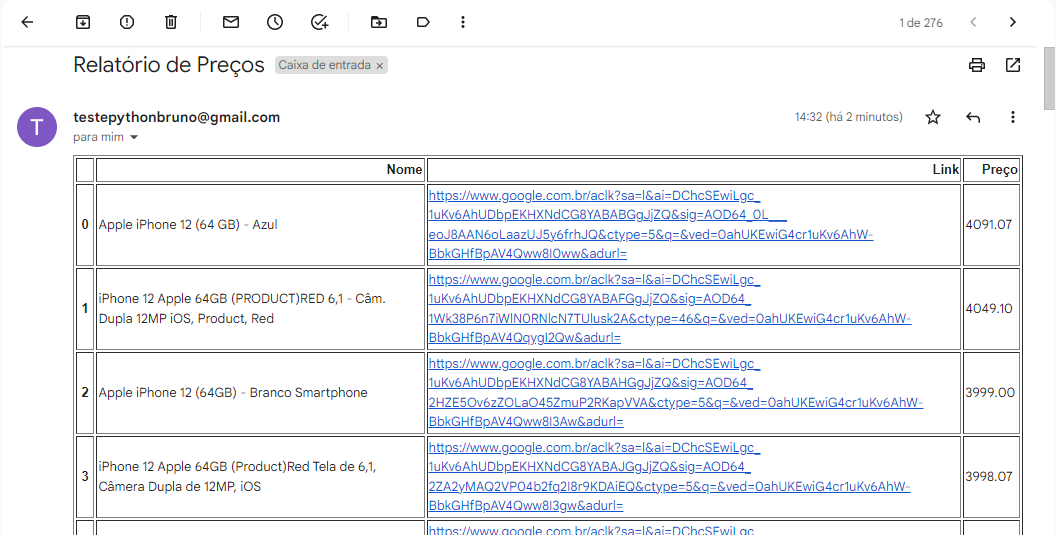

Lembrando que foi escolhido enviar a tabela diretamente por email utilizando html, porém, essa tabela tambem poderia ter sido salva no computador em formato excel.